# Осоновы работы c модулем nn в PyTorch
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1Yxt4XIaqrPXwgAoZWLTvs89_yj-cTUJu#scrollTo=9ic0H8b8qO5z)

## Импорт torch

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import transforms, datasets
import torchvision.transforms as T

import os
import random
import numpy as np
import matplotlib.pyplot as plt

Настроим работу с `PyTorch`. Выбирем формат работы и устройство для работы.

In [ ]:
def torch_stats(): 
    torch_version = ".".join(torch.__version__.split(".")[:2])
    print('torch version:',torch_version)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)
    dtype = torch.float32
    
    if device.type == 'cuda':
        cuda_version  = torch.__version__.split("+")[-1]
        print("cuda: ", cuda_version)
        
        torch.set_default_tensor_type(torch.cuda.FloatTensor)
        print('Cuda is available:',torch.cuda.is_available())

        n_devices = torch.cuda.device_count()
        print('number of devices: %d'%(n_devices))

        for cnt_device in range(n_devices):
            print(torch.cuda.get_device_name(cnt_device))
            print('Memory Usage:')
            print('Allocated:', round(torch.cuda.memory_allocated(cnt_device)/1024**3,1), 'GB')
            print('Cached:   ', round(torch.cuda.memory_reserved(cnt_device)/1024**3,1), 'GB')


    torch.set_default_dtype(dtype) # float32
    print('default data type:',dtype)
    
    num_workers=os.cpu_count()
    print ('available number of workers:',num_workers)
    
    return device, dtype, num_workers
#-------------------------------
def torch_seed(seed = 42, deterministic = True):
    random.seed(seed) # random and transforms
    np.random.seed(seed) #numpy
    torch.manual_seed(seed) #cpu
    torch.cuda.manual_seed(seed) #gpu
    torch.backends.cudnn.deterministic=deterministic #cudnn  

In [ ]:
device, dtype, num_workers = torch_stats()
torch_seed(seed = 42, deterministic = True)

torch version: 1.11
Using device: cpu
default data type: torch.float32
available number of workers: 2


# Модуль `torch.nn`

Как уже говорилось ранее модуль `torch.nn` содержит основные элементы для построения архитектур в рамках фреймворка `PyTorch`. 
Модуль предоставляет два типа API в классовом и процедурном стилях (подмодуль `torch.nn.functional`). В том числе модуль включает основные типы слоев нейронных сетей и основные функции активации и регуляризации. 

In [ ]:
import torch.nn.functional as F
from torch import nn

Для начала воспользуемся функцией `read_image` из модуля `torchvision.io` для загрузки произвольного изображения  в виде тензора в формате `PyTorch`. Для загрузки изобажения из интернета воспользуемся библиотекой `urllib`.

In [ ]:
import urllib.request
image_url = 'https://as2.ftcdn.net/v2/jpg/02/31/48/03/1000_F_231480357_TGpMz4r5HSFAlm43FkZ366FjFZuuoRA8.jpg'
urllib.request.urlretrieve(image_url,"image.png")

image = torchvision.io.read_image("image.png")
print(image.shape)

torch.Size([3, 667, 1000])


Обратите внимание, что для того, чтобы визуализровать изображение нам потребуется поменять разерности, так, как это показано ниже.

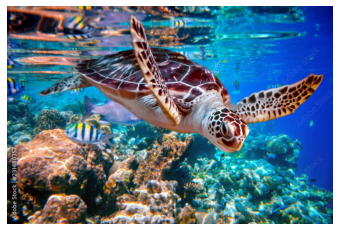

In [ ]:
img_ = image.data.numpy().transpose((1,2,0))
plt.imshow(img_, cmap='gray')
plt.axis('off')
plt.show()

Также, как это будет видно ниже, для нас будет важным число каналов в нашем изображении. 

In [ ]:
channels = image.shape[0]

Теперь попробуем создать двух-мерный фильтр с использованием класса `Conv2d`.
Для этого сначала запишим ядро фильтра в виде массива `NumPy`.

In [ ]:
#Sharpen
kernel = np.array([[ 0, -1,   0],
                   [-1,  5,  -1],
                   [ 0, -1,   0]])
print(kernel.shape)

(3, 3)


Теперь создадим экземпляр класса `nn.Conv2d` - нашу свертку. Для этого мы задаим:
* число входных каналов свертки (in_channels) - 3,
* число выходных каналов свертки (out_channels) - также 3,
* размер фильтра (kernel_size) = $3\times 3$, 
* шаг ядра (stride) = 1,
* степень расширения свертки (dilation) =1,
* число групп (groups) = 3,
* налчие параметра смещения (bias) - его нет.

Отметим, что в данном случае мы выставили число групп = 3. Это связано со спецификой операции свертка в `PyTorch`. В данном случае число групп равное числу каналов соотвествует тому, что применяемый фильтр воздействовать на каждый входной канал независимо. Если бы число групп было 1, то результат работы фильтра бы складывался для все входных каналов - что протеворечит классическому пониманию операции свертка. 

Тут также можно пояснить, что классчесое понимание операции свертка в большей степени соответствует т.н. depthwise convolution.

Принцип того, что мы тут сделали можно пояснить следующей иллюстрацией.

<img src="Conv2d_to_Classic.png" alt="Conv2d_to_Classic" title="Conv2d_to_Classic" width="950" /> 

In [ ]:
conv = nn.Conv2d(in_channels  = channels, 
                 out_channels = channels, 
                 kernel_size  = kernel.shape, 
                 stride       = 1, 
                 padding      = 1, 
                 dilation     = 1,
                 groups       = channels,
                 bias         = False)

Теперь преобразуем ядро в формат, совместимый с `PyTorch`. Для этого сделам массив тензором, установим тип данных и размерность.

Класс  `nn.Conv2d` предполагает, что ядро будет 4-х мерным тензором вида: $[\text{channels out}, \text{channels in}, \text{wide}, \text{height} ]$. Иллюстрация размерностей ядра приведена выше. Для получения нужных размерностей  мы установим $\text{channels out}$ равным желаемому числу каналов на выходе свертки (3 канала), число входных каналов 1, размер ядра $3\times 3$. 

Также проведем нормировку заданного фильтра, так, чтобы сумма модулей всех его значений была равна 1. 



In [ ]:
filter_ = torch.tensor(kernel).type(dtype)

norm = filter_.abs().sum()

filter_ = (filter_/norm).repeat(channels,1,1,1)

Задаим весовые параметры экземпляра свертка соответствующими нашему ядру. Для этого преобразуем веса в экземпляр класса `nn.Parameter`. Данная операция является требованием текущей версии `PyTorch`.

<!-- Операцию будем проводить с дерективой 
`torch.no_grad()`. -->

In [ ]:
conv.weight = nn.Parameter(filter_)

Теперь можно провести саму операцию свертки. Отметим, что для свертки мы приведем входное изображение к виду 4-х мерного тензора (форма: батч, каныл, ширина, высота). Для этого мы будем использовать операцию `unsqueeze`. После выполнения операции мы приведм размерность обратно при помощи обратной операции `squeeze`.

Результат операции преобразуем в тензор `NumPy` и приведем его к стандартному виду: диапазон значений $0...255$ (предполагается тип данных `uint8`). Для этого проведем стандартизацию результатов вида $$x' = 255\cdot\frac{x - min(x)}{max(x) - min(x)}.$$
Для выполнения данных процедурх запишим лямбда-выражение `standartize`.



In [ ]:
img_out = conv(torch.unsqueeze(image.to(device), 0).type(dtype)).squeeze()

standartize = lambda x: 255*(x - torch.min(x))/(torch.max(x)-torch.min(x))

for i in range(channels):
    img_out[i] = standartize(img_out[i])



Для визуализации результатов запишем функцию `show`. Данная функция будет выводить результа свертки, и, если необходимо, проводить эквивализации гистограммы. 

Также внутри функции мы проведм транспонирование размерностей чтобы привести их в соотвествие с ожидаемыми для бибилотеки визуализации `matplotlib`.

Последняя процедура часто делает результа визуализации более понятным. Для эквивализации используем преорбазования из библиотеки `torchvision`.

In [ ]:
def show(image, name='', equlize = True):

    image_ = torch.as_tensor(image).type(torch.uint8)
    
    if equlize:
        image_ = torchvision.transforms.functional.equalize(image_)
    
    image_ = image_.cpu().detach().numpy()
    image_ = image_.transpose(1,2,0)

    plt.imshow(image_,'gray');
    plt.axis('off'); 
    plt.title(name, fontsize = 24); 
    plt.show(); 

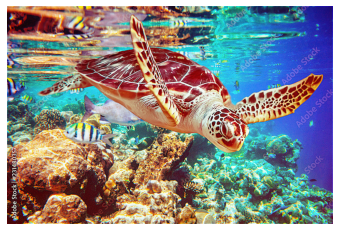

In [ ]:
show(img_out,equlize = True)

Отметим также, что `PyTorch` также позволяет работать с частью своего функционала в процедурном стиле. Часть функций в данном стиле доступны в `torch.nn.functinal`, другие напрямую из `torch`. Приведем пример реализации свертки в фунциональном стиле и добавим к ней функии пулинга и активации в фунциональном стиле.

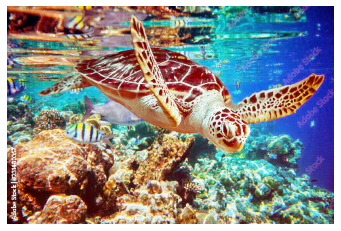

In [ ]:
import torch.nn.functional as F

out = F.conv2d(input = torch.unsqueeze(image,0).type(dtype),
               weight = filter_, 
               bias=torch.zeros(filter_.shape[0]), 
               stride=1,
               padding=0, 
               dilation=1, 
               groups=filter_.shape[0]).squeeze(0)
out = torch.relu(out)
out = F.max_pool2d(out,(2,2),stride=2)


for i in range(channels):
    out[i] = standartize(out[i])
    
show(out, name='', equlize = True)

Объеденим полученные результаты вместе. 
Для этого создадим базовый класс `Pipeline_nn_base`. Класс будет включать:
* конструктор, позволяющий задать изобажение и тип данных;
* метод задания нового изображения (set_image);
* метод получение изображения (get_image);
* метод чтение изображения с диска (read_image);
* метод преобразований изображения (transform);
* метод show.

В классе `Pipeline_nn_base` мы будем использовать прием построения цепочек, который организуем при помощи `return self`.
Ометим, что данный класс включает базовые методы для последующей работы, полагаем, что на него не следует обращать внимение при первом изучнеии данного материала.




In [ ]:
class Pipeline_nn_base:
    def __init__(self, image = None, dtype = torch.float):
        self.dtype = dtype
        if image is not None:
            self.set_image(image)

    #--------------------------
    def set_image(self, image):

        self.image = torch.as_tensor(image)
        
        if self.image.ndim<4:
            self.image = torch.unsqueeze(image,0)
            
        self.channels = self.image.shape[1]

        self.image.type(self.dtype)
        return self
    
    #--------------------------
    def read_image(self, path):
        image = torchvision.io.read_image(path)
        self.set_image(image)
        return self
    
    #--------------------------
    def transform(self, transforms):
        self.image = transforms(self.image)
        return self

    #--------------------------
    def get_image(self, equlize = True):
        img_out = torch.squeeze(self.image)

        standartize = lambda x: \
            255*(x - torch.min(x))/(torch.max(x)-torch.min(x))

        for i in range(channels):
            img_out[i] = standartize(img_out[i])
            
        img_out = img_out.type(torch.uint8)
        
        if equlize:
            img_out = T.functional.equalize(img_out)
       
        img_out = img_out.cpu().detach().numpy()
        img_out = (img_out.transpose(1,2,0))
        return img_out
    
    #--------------------------
    def show(self, name = '', equlize = True):
        image_ = self.get_image(equlize)
        plt.imshow(image_,'gray');
        plt.axis('off'); 
        plt.title(name, fontsize = 24); 
        plt.show(); 
        
        return self


Запишем класс `Pipeline_nn`, который будет включать метод метод свертка (`convolution`) и вспомогательный приватный метод расчета параметров ядра.
Отметим, что для свертки мы будем вычислять padding таким образом чтобы выходное изображение имело эквивалентный размер входному изображению.

In [ ]:
class Pipeline_nn(Pipeline_nn_base):
    #--------------------------
    def convolution(self, kernel, stride = (1,1), dilation = (1,1) ):

        dilation, padding, filter_ = self._kernel_parameters(kernel, dilation)
        
        conv = nn.Conv2d(in_channels  = self.channels, 
                         out_channels = self.channels, 
                         kernel_size  = kernel.shape, 
                         stride       = stride, 
                         padding      = 0, 
                         dilation     = dilation,
                         groups       = self.channels,
                         bias         = False)
        

        conv.weight = nn.Parameter(filter_).cpu()

        self.image = conv(self.image.type(self.dtype).cpu())
        return self

    #--------------------------
    def _kernel_parameters(self, kernel, dilation):
        if np.asarray(dilation).ndim<1:
            dilation=(dilation,dilation) #tuple expected 
        
        # paddig calculation    
        padding = (dilation[0]*(kernel.shape[0]-1)//2,  
                   dilation[1]*(kernel.shape[1]-1)//2)        
        
        filter_ = torch.tensor(kernel).type(self.dtype).cpu()
        
        norm = filter_.abs().sum()

        filter_ = (filter_/norm).repeat(channels,1,1,1)
        
        return  dilation, padding, filter_

Проверим работоспособность созданного класса.

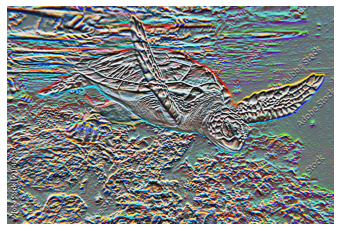

In [ ]:
#Scharr edge detection in vertical 
kernel = np.array([[-3, -10, -3],
                   [ 0,  0,   0],
                   [ 3,  10,  3]])

test = Pipeline_nn()

preprocess = T.Compose([
               T.GaussianBlur(kernel_size=3),  
               T.ColorJitter(brightness=1.5),
               ])

test.read_image("image.png").transform(preprocess).convolution(kernel).show(equlize = True);


Теперь давайте попробуем релаизвать в при помощи тех же принципах дополнительный функционал, доступный в модуле `torch.nn`. Добавим возможность вызова функций активации при помощи метода `activation`, а также возможности для передескретизации при помощи методов `maxpooling` и `avpooling`.

In [ ]:
class Pipeline_nn_v2(Pipeline_nn):
    def __init__(self, image = None, dtype = torch.float):
        super().__init__(image, dtype)
        self.pool_indexes = None
    #----------------------------------------------
    def activation(self, activation_cls = None):
        if activation_cls is not None:
            self.image = activation_cls()(self.image)
        return self
    
    #----------------------------------------------
    def maxpooling(self, size = (2,2), stride = (2,2)):
        pool = nn.MaxPool2d(kernel_size = size,
                            stride   = stride,
                            padding  = 0,
                            dilation = 1,
                            return_indices = True,)
        
        self.image, pool_indexes = pool(self.image)
        self.pool_indexes = pool_indexes
        return self

    #----------------------------------------------
    def avpooling(self, size = (2,2), stride = (2,2)):
        pool = nn.AvgPool2d(kernel_size = size,
                            stride   = stride,
                            padding  = 0,)
        
        self.image = pool(self.image)
        return self 
    

        

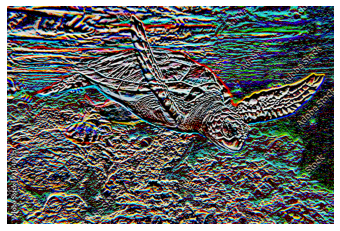

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


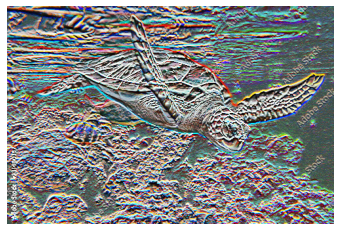

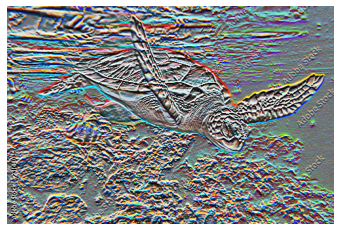

In [ ]:
#Scharr edge detection in vertical 
kernel = np.array([[-3, -10, -3],
                   [ 0,  0,   0],
                   [ 3,  10,  3]])

test = Pipeline_nn_v2()

test.read_image("image.png").convolution(kernel).activation(nn.ReLU).show(equlize = True)

test.read_image("image.png").convolution(kernel).maxpooling().show(equlize = True)

test.read_image("image.png").convolution(kernel).avpooling().show(equlize = True);



Также попробуем добавить обратные операции: транспонированную свертку (`transpose_convolution`), обратный max pooling (`maxunpooling`) и билинейную интерполяцию (`bilinear_upsampling`).

In [ ]:
class Pipeline_nn_v3(Pipeline_nn_v2):

    #----------------------------------------------
    def transpose_convolution(self, kernel, stride = (1,1), dilation = (1,1) ):

        dilation, padding, filter_ = self._kernel_parameters(kernel, dilation)
        
        conv = nn.ConvTranspose2d(in_channels  = self.channels, 
                                  out_channels = self.channels, 
                                  kernel_size  = kernel.shape, 
                                  stride       = stride, 
                                  padding      = padding, 
                                  dilation     = dilation,
                                  groups       = self.channels,
                                  bias         = False)
        

        conv.weight = nn.Parameter(filter_)
        
        self.image = conv(self.image.type(self.dtype))
        return self   
    #----------------------------------------------
    def maxunpooling(self, size =(2,2), stride = (2,2)):
            
        if   self.pool_indexes is not None:  
            unpool = nn.MaxUnpool2d(kernel_size = size,
                                    stride   = stride,
                                    padding  = 0,)

            self.image = unpool(self.image, self.pool_indexes)

        return self
    #----------------------------------------------
    def bilinear_upsampling(self, scale_factor = 2):
            
        if   self.pool_indexes is not None:  
            unpool = nn.UpsamplingBilinear2d(scale_factor=scale_factor)

            self.image = unpool(self.image)

        return self

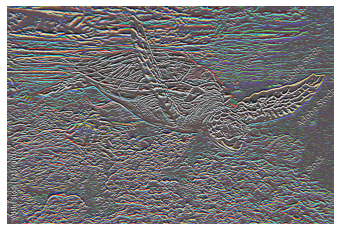

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


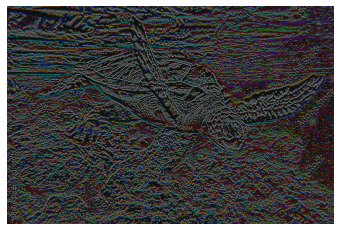

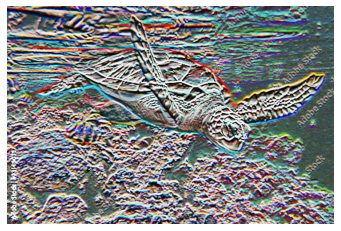

In [ ]:
#Scharr edge detection in vertical 
kernel = np.array([[-3, -10, -3],
                   [ 0,  0,   0],
                   [ 3,  10,  3]])

test = Pipeline_nn_v3()


test.read_image("image.png").convolution(kernel).activation(nn.ReLU).transpose_convolution(kernel).show(equlize = True)

test.read_image("image.png").convolution(kernel).maxpooling().maxunpooling().show(equlize = True)

test.read_image("image.png").convolution(kernel).maxpooling().bilinear_upsampling().show(equlize = True);

Также добавим возможность для регуляризации (нормализация или дроп-аут). Отметим, что в данном случае мы будем использовать т.н. `DropOut2D`, "выключающий" сразу по целому каналу.

In [ ]:
class Pipeline_nn_v4(Pipeline_nn_v3):

    def regularization(self, norm_type = 'BatchNorm'):
        if norm_type == 'InstantNorm':
            self.image = nn.InstanceNorm2d(self.channels, device='cpu')(self.image)
        elif norm_type == 'LayerNorm':
            self.image = nn.LayerNorm(self.image.shape[1:], device='cpu')(self.image)
        elif norm_type == 'BatchNorm':
            self.image = nn.BatchNorm2d(self.channels, device='cpu')(self.image)
        elif norm_type == 'GroupNorm':
            self.image = nn.GroupNorm(self.channels,self.channels, device='cpu')(self.image)            
        elif norm_type == 'LocalResponseNorm':
            self.image = nn.LocalResponseNorm(self.channels, device='cpu')(self.image) 
        elif norm_type == 'DropOut':
            self.image = nn.Dropout2d(p=0.4)(self.image)  
        
        return self

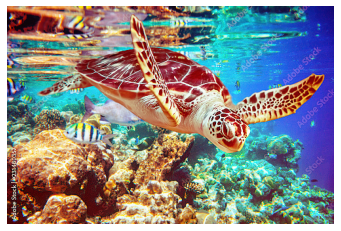

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


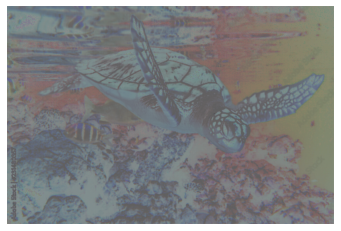

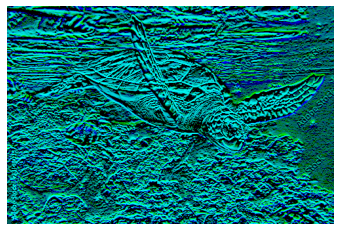

In [ ]:
kernel2 = np.array([[-3, -10, -3],
                   [ 0,  0,   0],
                   [ 3,  10,  3]])

kernel1 = np.array([[ 0, -1,   0],
                    [-1,  5,  -1],
                    [ 0, -1,   0]])

test = Pipeline_nn_v4()

test.read_image("image.png").convolution(kernel1).avpooling().regularization('BatchNorm').show(equlize = True)

test.read_image("image.png").convolution(kernel1).maxpooling().transpose_convolution(kernel1,stride=2).show(equlize = True)

test.read_image("image.png").convolution(kernel2).regularization('DropOut').activation(nn.ELU).avpooling().show(equlize = True);

Помимо базовых слоев, примеры которых были показаны выше в `PyTorch` могут быть проведены некоторые преобразования входных данных - то есть их аугментация. 

Напомним, что агумтенация данных может выполняться статически - для всего набора данных перед обучением или динамически (во время загрузки батчей). Чаще всего рекомендуется последний путь. 

Аугментацию можно сделать с помощью преобразований `transforms`, из дополнительной библиотеки `torchvision` например, так, как это показано ниже.

Отметим, что `torchvision.transforms` позволяет работать с форматами `numpy`, `pillow (PIL)` и тензорами изображений. Большенство преобразований `torchvisiontransforms` работают с форматом `PIL`. Список преобразований можно найти [тут](https://pytorch.org/vision/stable/transforms.html).  Больше примеров преобразований можно найти [тут](
https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py).

Также отметим, что помимо стандартных методов работы с тензорами `torchvision` существует ряд сторонних проектов для помощи аугметнации. Одним из наиболее популярных среди таковых является библиотека `albumentations`, официальная документация и примеры по работе с которой могут быть найдены [тут](https://albumentations.ai/docs/).

In [ ]:
class Pipeline_nn_v5(Pipeline_nn_v4):

    def transform(self,  transforms= None):

        if transforms is not None:
            self.image = transforms(image)
        
        # transforms could sqeeze dim for batch size = 1
        if self.image.ndim<4:
            self.image = torch.unsqueeze(self.image, 0)

        return self


Аугментация в torchvision может быть реализована как последовательностью (цепочкой) преобразований, так и индивидуальными преобразованиями. Для создания цепочек преобразований необходимо использовать класс `T.Compose`.

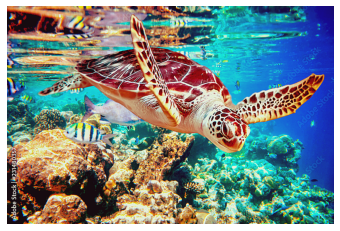

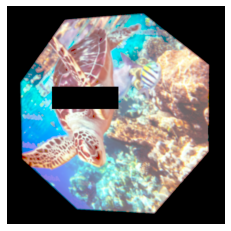

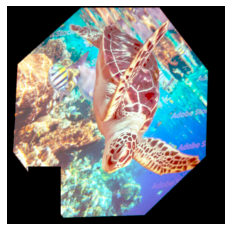

In [ ]:
import torchvision.transforms as T
kernel_size = 9
transforms1 = T.ColorJitter(brightness=(0.3,1.5), contrast=(1.1,2.5))
transforms2 = T.Compose([
                    T.Resize((900, 900)), 
                    T.RandomCrop(800),
                    T.RandomRotation(degrees=120),
                    T.Lambda(lambda x:torch.abs(x**1.5)),
                    T.RandomPerspective(distortion_scale=0.2, p=1),
                    T.GaussianBlur(kernel_size=kernel_size),    
                    T.RandomApply([T.RandomErasing(p=1, scale=(0.02, 0.05),),T.RandomHorizontalFlip()],p=0.6), 
                    T.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
                   ])

test = Pipeline_nn_v5()

test.read_image("image.png").transform(transforms1).convolution(kernel1).show(equlize = True);
test.read_image("image.png").transform(transforms2).regularization('BatchNorm').show(equlize = True);
test.read_image("image.png").transform(transforms1).transform(transforms2).show(equlize = True);

Обратите внимание, что часто рекомендуется после выполнения преобразований провести нормализацию `T.Normalize(mean, std)`. При этом заданные константы среднего и сдандартного отклонения определены эмпирически для достаточно крупных наборов данных. Часто для трех-канальных (RGB) изображений рекомендуемые значения  $mean = [0.485, 0.456, 0.406]$ и $std = [0.229, 0.224, 0.225]$. Данные значения получены путем усреднения по набору данных `ImageNet2012`, разъяснение можно найти [тут](https://github.com/pytorch/vision/pull/1965) и [тут](https://github.com/pytorch/vision/issues/1439). Для черно-белых изображений рекомендуемые значения $mean=[0.445]$ и $std=[0.2692]$.

Упражнение 
1. Дополните функционал базового класса методом вывода размерности изображений.
2. Проверьте результаты работы других типов классических фильтров, например:
    <!-- $$ -->
    \begin{gathered}
    \text{Гауссов фильтр: } {\frac {1}{16}}{\begin{bmatrix}\ \ 1&\ \ 2&\ \ 1\\\ \ 2&\ \ 4&\ \ 2\\\ \ 1&\ \ 2&\ \ 1\end{bmatrix}} 
    \\
    \text{Тиснение изображения:}  \begin{bmatrix}\ \ -2&\ \ -1&\ \ 0\\\ \ -1&\ \ 1&\ \ 1\\\ \ 0&\ \ 1&\ \ 2\end{bmatrix}
    \\
     \text{Диаганальный фильтр Собеля:}  \begin{bmatrix} \ \ -2&\ \ -1&\ \ 0\\\ \ -1&\ \ 0&\ \ 0\\\ \ 1&\ \ 2&\ \ 2\end{bmatrix}
     \end{gathered}
    <!-- $$ -->
    
2. Проверьте результаты работы функционала модуля `nn` (изображения и их размеры) для случаев:
    * увеличенного шага свертки (stride);
    * расширенной свертки (dilation);
    * увеличенного шага свертки (stride) + bilinear interpolation;
    * обратная свертка (transposed convolution) c разными параметрами;
    * произвольные комбинации прямой и обратной свертки с использованием полулинейных функций активации и слоев регуляризации.